<a href="https://colab.research.google.com/github/danielajisafe/ASR-Nigeria-Pidgin/blob/main/ASR_Nigeria_Pidgin_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the official impementation of the paper "**Towards end-end Training of Automatic Speech Recognition for Nigerian Pidgin**"

Import necessary libaries

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2


from IPython import display

## Install NeMo
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

## The AN4 dataset

-  This dataset is preliminary and optional. But highly recommened you follow the instructions in order to set up smoothly.

In [ ]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [ ]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [ ]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In [ ]:
!pip install matplotlib==3.1

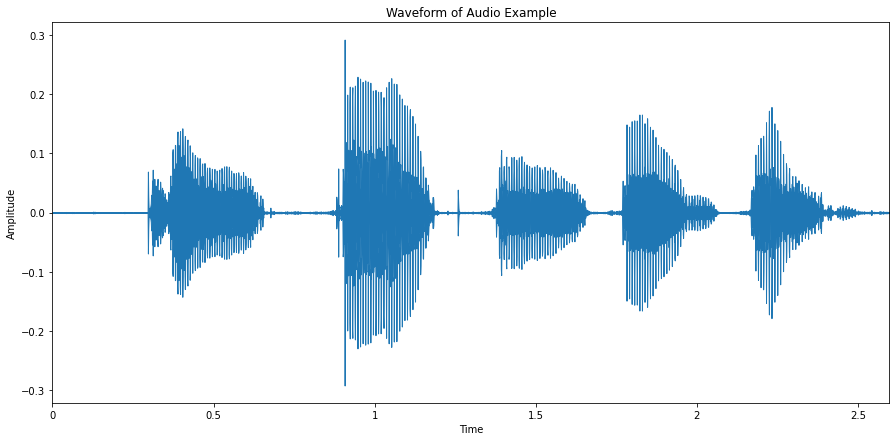

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

### Spectrograms and Mel Spectrograms

In [ ]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

In [ ]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Convolutional ASR Models


### Using NeMo for Automatic Speech Recognition


In [ ]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


[NeMo W 2020-10-19 11:25:01 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-19 11:25:01 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-19 11:25:01 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-19 11:25:01 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-19 11:25:01 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

### Creating Data Manifests

Creating manifests for our training and evaluation data, which will contain the metadata of our audio files. 

In [ ]:
#link in the data from your Google drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/My Drive/Speech_Recognition/All_Speech_Data_Folder.zip' -d "/content/an4/wav/"

In [ ]:
from glob import glob

# Counting the total number of audios.
len(os.listdir('/content/an4/wav/All_Final_Folder/All_Audios')) 

8454

In [ ]:
%%time
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******************************************")
#train_manifest.json, validation_manifest.json and test_manifest.json would be empty files

# train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_transcripts = '/content/an4/wav/All_Final_Folder/Train_Transcribe'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    # build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    build_manifest(train_transcripts, train_manifest, '/content/an4/wav/All_Final_Folder/All_Audios/')
    print("Training manifest created.")

# val_transcripts = data_dir + '/an4/etc/an4_val.transcription'
validation_transcripts = '/content/an4/wav/All_Final_Folder/Validation_Transcribe'
validation_manifest = data_dir + '/an4/validation_manifest.json'
if not os.path.isfile(validation_manifest):
    # build_manifest(val_transcripts, val_manifest, 'an4/wav/an4_clstk')
    build_manifest(validation_transcripts, validation_manifest, '/content/an4/wav/All_Final_Folder/All_Audios/')
    print("Validation manifest created.")

# test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_transcripts = '/content/an4/wav/All_Final_Folder/Test_Transcribe'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    # build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    build_manifest(test_transcripts, test_manifest, '/content/an4/wav/All_Final_Folder/All_Audios/')
    print("Test manifest created.")
print("***Done***")

******************************************
Training manifest created.
Validation manifest created.
Test manifest created.
***Done***
CPU times: user 47.2 s, sys: 2min 40s, total: 3min 28s
Wall time: 15min 58s


### Specifying the Model with a YAML Config File

In [ ]:
# --- Config Information ---#
from ruamel.yaml import YAML
config_path = './configs/config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False}, 'preprocessor': {'cls': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'params': {'normalize': 'per_feature', 'window_s

In [ ]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
model_name="QuartzNet15x5Base-En"  ##QuartzNet15x5Base-En #Jasper10x5Dr-En
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name=model_name)

[NeMo I 2020-10-19 11:46:33 cloud:65] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2020-10-19 11:46:39 common:395] Instantiating model from pre-trained checkpoint


[NeMo W 2020-10-19 11:46:40 nemo_logging:349] /usr/local/lib/python3.6/dist-packages/hydra/_internal/utils.py:638: UserWarning: 
    Config key 'cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
    Use '_target_' instead of 'cls'.
    See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/object_instantiation_changes
      warnings.warn(message=msg, category=UserWarning)
    
[NeMo W 2020-10-19 11:46:40 nemo_logging:349] /usr/local/lib/python3.6/dist-packages/hydra/_internal/utils.py:584: UserWarning: 
    Field 'params' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
    Inline the content of params directly at the containing node.
    See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/object_instantiation_changes
      warnings.warn(category=UserWarning, message=msg)
    


[NeMo I 2020-10-19 11:46:40 features:241] PADDING: 16
[NeMo I 2020-10-19 11:46:40 features:258] STFT using torch
[NeMo I 2020-10-19 11:46:53 modelPT:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


In [ ]:
#does it have augmentation?
print(quartznet._cfg['spec_augment'])

{'cls': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'params': {'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}}


Turn off Augmentation ? 

In [ ]:
# Turn off Augmentation ? #commenting
# quartznet._cfg['spec_augment'] = {}

In [ ]:
# Check what kind of vocabulary/alphabet the model has right now
print('old:', quartznet.decoder.vocabulary)

# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    # new_vocabulary=[
    #     ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
    #     'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    # ]
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'ç', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'", "!"
    ]
)
print('new:', quartznet.decoder.vocabulary)

[NeMo W 2020-10-19 11:46:53 nemo_logging:349] /usr/local/lib/python3.6/dist-packages/hydra/_internal/utils.py:638: UserWarning: 
    Config key 'cls' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
    Use '_target_' instead of 'cls'.
    See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/object_instantiation_changes
      warnings.warn(message=msg, category=UserWarning)
    
[NeMo W 2020-10-19 11:46:53 nemo_logging:349] /usr/local/lib/python3.6/dist-packages/hydra/_internal/utils.py:584: UserWarning: 
    Field 'params' is deprecated since Hydra 1.0 and will be removed in Hydra 1.1.
    Inline the content of params directly at the containing node.
    See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/object_instantiation_changes
      warnings.warn(category=UserWarning, message=msg)
    


old: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2020-10-19 11:46:53 ctc_models:203] Changed decoder to output to [' ', 'a', 'b', 'c', 'ç', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'", '!'] vocabulary.
new: [' ', 'a', 'b', 'c', 'ç', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'", '!']


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune-this model for 2 epochs on AN4 dataset. We will also use the smaller learning rate from ``new_opt` (see the "After Training" section)`.

In [ ]:
params['model']['test_ds'] = {'batch_size': 4,
  'labels': [' ',
   'a',
   'b',
   'c',
   'd',
   'e',
   'f',
   'g',
   'h',
   'i',
   'j',
   'k',
   'l',
   'm',
   'n',
   'o',
   'p',
   'q',
   'r',
   's',
   't',
   'u',
   'v',
   'w',
   'x',
   'y',
   'z',
   "'"],
  'manifest_filepath': './an4/test_manifest.json',
  'sample_rate': 16000,
  'shuffle': False}

In [ ]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = validation_manifest
params['model']['test_ds']['manifest_filepath'] = test_manifest

# Bigger batch-size = bigger throughput
params['model']['train_ds']['batch_size'] = 4
params['model']['validation_ds']['batch_size'] = 4
params['model']['test_ds']['batch_size'] = 2

print(params['model']['optim'])

import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001

print('new_opt', new_opt)

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}
new_opt {'name': 'novograd', 'lr': 0.001, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


In [ ]:
new_vocabulary=[
        ' ', 'a', 'b', 'c', 'ç', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'", "!"
    ]

params['model']['train_ds']['labels'] = new_vocabulary
params['model']['validation_ds']['labels'] = new_vocabulary
params['model']['test_ds']['labels'] = new_vocabulary


## Confirm the setup train vs Val data

In [ ]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

[NeMo I 2020-10-19 11:46:56 modelPT:578] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2020-10-19 11:46:56 lr_scheduler:534] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2020-10-19 11:46:57 collections:173] Dataset loaded with 6107 files totalling 10.92 hours
[NeMo I 2020-10-19 11:46:57 collections:174] 71 files were filtered totalling 0.45 hours
[NeMo I 2020-10-19 11:46:57 collections:173] Dataset loaded with 759 files totalling 1.64 hours
[NeMo I 2020-10-19 11:46:57 collections:174] 0 files were filtered totalling 0.00 hours


In [ ]:
#confirm if Augmentation is off if wanted /not
print(quartznet._cfg['spec_augment'])

{'cls': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'params': {'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}}


In [ ]:
# quartznet

In [ ]:
%%time

# And now we can create a PyTorch Lightning trainer and call `fit` again.
import pytorch_lightning as pl

n_epochs = 5
trainer = pl.Trainer(gpus=[1], max_epochs=n_epochs)
trainer.fit(quartznet)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2020-10-19 11:46:57 modelPT:578] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2020-10-19 11:46:57 lr_scheduler:534] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
[NeMo W 2020-10-19 11:46:57 nemo_logging:349] /usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
      warnings.warn(*args, **kwargs)
    

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18 M  
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 42 K  
5 | loss     

[NeMo I 2020-10-19 11:46:58 wer:148] 
    
[NeMo I 2020-10-19 11:46:58 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 11:46:58 wer:150] decoded  :jgj1ijzbnimzm3'jw3bhbjcb1b1iyz1b g pwmaqkqryzw3hbahd'zagjbizdaç1dpbj3n3mw3mwqib1adai1v13j3djrqkjphpajfzba'0'2dzdx2'dh ni12f2d2d2zabicdbrdaiqapjdjrdjrjd3rd72d7iaiazdjurpajv1ajadjdjdjfjdj'babvnan5'0 8j8j1b'tajal8md3q1qj1jd3mdjm3mzjb1aj5j3j8w'j 1azkjbdimbjcdjbnb1aijdibibpaifdfbj1a' jajw'0gjv8mj


[NeMo I 2020-10-19 11:46:58 wer:148] 
    
[NeMo I 2020-10-19 11:46:58 wer:149] reference:na dream wey i don get since i be pikin
[NeMo I 2020-10-19 11:46:58 wer:150] decoded  :jmac4dczjw'zajzjmjmzj3'baai3cw2wyqzjw'twjmaj9çjçj6jkdmjmdrjababzijbajazjajaj5zm5dzmdivdq
[NeMo I 2020-10-19 11:46:59 wer:148] 
    
[NeMo I 2020-10-19 11:46:59 wer:149] reference:buhari de confuse himself for say him support make western sahara comot for morroco but him no gree make biafra comot for nigeria
[NeMo I 2020-10-19 11:46:59 wer:150] decoded  :bj6jkj'bz3rarkcc3'0w1aw1sadbgda3b13jzij1acjaj3brwn3jbjb3w3wbwq w'bajmpanj3aba1aç1zbc3iazp3jkpbrczw3ibaryz3pqyz kbwazw1w2wr63'ba3jaijbajiaijqjajickz5bvzd5dajxyc5ibjdnd3baj1qa3jbj13b13jcdhzr1dvpaj1anm3j3m38 'brmz3j1ipaj8dydb31dapdjzj'zajiyacj3j3j3dj8z bavpapmwaba3mdjb19cd3b65bid5abar8zibajicjibr8alj1waazwjbzjy1z3jad
[NeMo I 2020-10-19 11:47:00 wer:148] 
    
[NeMo I 2020-10-19 11:47:00 wer:149] reference:wen dem reach dia na so she see her pikin among di 11 childre

[NeMo I 2020-10-19 12:06:06 wer:148] 
    
[NeMo I 2020-10-19 12:06:06 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 12:06:06 wer:150] decoded  :isdmember foletroal consitanty onoabugi melam niway say dem don suspentd d protest march wey dey
[NeMo I 2020-10-19 12:06:06 wer:148] 
    
[NeMo I 2020-10-19 12:06:06 wer:149] reference:elecam change e stand afta deh bin say polling unit for palace
[NeMo I 2020-10-19 12:06:06 wer:150] decoded  :leam tra di itan after dey be say pola umits for palas
[NeMo I 2020-10-19 12:06:07 wer:148] 
    
[NeMo I 2020-10-19 12:06:07 wer:149] reference:cameroon go vote for president on october 7 and na
[NeMo I 2020-10-19 12:06:07 wer:150] decoded  :cammein go vos for prossident on octobar 7and na
[NeMo I 2020-10-19 12:06:07 wer:148] 
    
[NeMo I 2020-10-19 12:06:07 wer:149] reference:ari talk am on monday for jos for the itf 2017 end of
[NeMo I 2020-10-

[NeMo I 2020-10-19 12:26:06 wer:148] 
    
[NeMo I 2020-10-19 12:26:06 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 12:26:06 wer:150] decoded  :is di member for niror constitency nobugi icla nitoe say dem don souspend do protest mutch wey dey
[NeMo I 2020-10-19 12:26:07 wer:148] 
    
[NeMo I 2020-10-19 12:26:07 wer:149] reference:elecam change e stand afta deh bin say polling unit for palace
[NeMo I 2020-10-19 12:26:07 wer:150] decoded  :liam tri di istand afte dey been say pole units for pallar
[NeMo I 2020-10-19 12:26:07 wer:148] 
    
[NeMo I 2020-10-19 12:26:07 wer:149] reference:cameroon go vote for president on october 7 and na
[NeMo I 2020-10-19 12:26:07 wer:150] decoded  :camirin go vote for prosten don october 7and now
[NeMo I 2020-10-19 12:26:07 wer:148] 
    
[NeMo I 2020-10-19 12:26:07 wer:149] reference:ari talk am on monday for jos for the itf 2017 end of
[NeMo I 20

[NeMo I 2020-10-19 12:46:03 wer:148] 
    
[NeMo I 2020-10-19 12:46:03 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 12:46:03 wer:150] decoded  :is demember for litoral constitency onobuji weclai nitrowel say dem don suspend do protest match wey dey
[NeMo I 2020-10-19 12:46:03 wer:148] 
    
[NeMo I 2020-10-19 12:46:03 wer:149] reference:elecam change e stand afta deh bin say polling unit for palace
[NeMo I 2020-10-19 12:46:03 wer:150] decoded  :laa trig d istar after dey been stay poli units for palac
[NeMo I 2020-10-19 12:46:04 wer:148] 
    
[NeMo I 2020-10-19 12:46:04 wer:149] reference:cameroon go vote for president on october 7 and na
[NeMo I 2020-10-19 12:46:04 wer:150] decoded  :camirin go vose for prossident don october 77 asd no
[NeMo I 2020-10-19 12:46:04 wer:148] 
    
[NeMo I 2020-10-19 12:46:04 wer:149] reference:ari talk am on monday for jos for the itf 2017 end of
[

[NeMo I 2020-10-19 13:06:11 wer:148] 
    
[NeMo I 2020-10-19 13:06:11 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 13:06:11 wer:150] decoded  :nisdeat member for litural consitancy onoabuji wiclam netruell say dem don suspend de portest match wey dey
[NeMo I 2020-10-19 13:06:11 wer:148] 
    
[NeMo I 2020-10-19 13:06:11 wer:149] reference:elecam change e stand afta deh bin say polling unit for palace
[NeMo I 2020-10-19 13:06:11 wer:150] decoded  :leateam thrai ti istan after dey bien say pola units for paace
[NeMo I 2020-10-19 13:06:12 wer:148] 
    
[NeMo I 2020-10-19 13:06:12 wer:149] reference:cameroon go vote for president on october 7 and na
[NeMo I 2020-10-19 13:06:12 wer:150] decoded  :camerin go vote for president on october 7 and now
[NeMo I 2020-10-19 13:06:12 wer:148] 
    
[NeMo I 2020-10-19 13:06:12 wer:149] reference:ari talk am on monday for jos for the itf 2017 en

[NeMo I 2020-10-19 13:26:32 wer:148] 
    
[NeMo I 2020-10-19 13:26:32 wer:149] reference:sdf member for littoral constituency honourable jean michel nintcheu say deh don suspend de protest march weh deh
[NeMo I 2020-10-19 13:26:32 wer:150] decoded  :inmember for latural constitensy onablu gin miclam neue say dem don suspend ti protest match wey dey
[NeMo I 2020-10-19 13:26:33 wer:148] 
    
[NeMo I 2020-10-19 13:26:33 wer:149] reference:elecam change e stand afta deh bin say polling unit for palace
[NeMo I 2020-10-19 13:26:33 wer:150] decoded  :alae am thrai di istand after dey bien say poling units for paac
[NeMo I 2020-10-19 13:26:33 wer:148] 
    
[NeMo I 2020-10-19 13:26:33 wer:149] reference:cameroon go vote for president on october 7 and na
[NeMo I 2020-10-19 13:26:33 wer:150] decoded  :camerroo go vooe for president on october 7 and now
[NeMo I 2020-10-19 13:26:33 wer:148] 
    
[NeMo I 2020-10-19 13:26:33 wer:149] reference:ari talk am on monday for jos for the itf 2017 end of

Saving latest checkpoint..



CPU times: user 1h 12min 28s, sys: 26min 8s, total: 1h 38min 36s
Wall time: 1h 40min 23s


In [ ]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir lightning_logs/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

<IPython.core.display.Javascript object>

In [ ]:
try:
  from google import colab
  COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
  COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
  %load_ext tensorboard
  %tensorboard --logdir lightning_logs/
else:
  print("To use tensorboard, please use this notebook in a Google Colab environment.")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
import gc
gc.collect()

5365

### Run Inference

In [ ]:
%%time

# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 1

# Setup the test data loader and make sure the model is on GPU
quartznet.setup_test_data(test_data_config=params['model']['validation_ds'])
quartznet.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in quartznet.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = quartznet(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        wer_num, wer_denom = quartznet._wer(greedy_predictions, targets, targets_lengths)
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        #clear output
        display.clear_output(wait=True)

# We need to sum all numerators and denominators first. Then divide.

result = round(sum(wer_nums)/sum(wer_denoms), 2)
print(f"WER = {result}")

WER = 0.77
CPU times: user 1min 39s, sys: 8.86 s, total: 1min 47s
Wall time: 1min 48s


In [ ]:
if quartznet._cfg['spec_augment'] == {}:
  data_aug ='no'

else:
  data_aug ='yes'

from datetime import datetime
time = datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

WER = 0.7729722064662508


In [ ]:
f = open("output.txt", "a")
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}, epochs: {n_epochs} model_name: {model_name} data_augmentation: {data_aug} timestamp: {time}", file=f)
f.close()

In [ ]:
wer_i_got = result
quartznet.save_to('/content/lightning_logs/{}_model_{}_{}.pth'.format(model_name, wer_i_got, time))

In [ ]:
!zip -r lightning_logs.zip '/content/lightning_logs' > /dev/null

In [ ]:
# f = open("/content/gdrive/My Drive/Speech_Recognition/Nemo_All/output.txt", "a")
# print(f"WER = {sum(wer_nums)/sum(wer_denoms)}", file=f)
# f.close()

## Loading a trained model

In [ ]:
#to restore your weights, you can rebuild the model using the config 
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=1)

from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
trained_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

#(let's say you call it first_asr_model_continued this time) 
trained_asr_model.restore_from('/content/lightning_logs/model.pth')

In [ ]:
trained_asr_model.restore_from?

### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can use [PyTorch Lightning's Trainer object](https://pytorch-lightning.readthedocs.io/en/latest/trainer.html) to handle mixed-precision and distributed training for you. Below are some examples of flags you would pass to the `Trainer` to use these features:

```python
# Mixed precision:
trainer = pl.Trainer(amp_level='O1', precision=16)

# Trainer with a distributed backend:
trainer = pl.Trainer(gpus=2, num_nodes=2, distributed_backend='ddp')

# Of course, you can combine these flags as well.
```

Finally, have a look at [example scripts in NeMo repository](https://github.com/NVIDIA/NeMo/blob/main/examples/asr/speech_to_text.py) which can handle mixed precision and distributed training using command-line arguments.

### Deployment

Let's get back to our pre-trained model and see how easy it can be exported to an ONNX file
in order to run it in an inference engine like TensorRT or ONNXRuntime.
If you don't have one, let's install it:

In [ ]:
!mkdir ort
!cd ort
!git clone --depth 1 --branch v1.5.1 https://github.com/microsoft/onnxruntime.git .
!./build.sh --skip_tests --config Release --build_shared_lib --parallel --use_cuda --cuda_home /usr/local/cuda --cudnn_home /usr/lib/x86_64-linux-gnu --build_wheel
!pip install ./build/Linux/Release/dist/onnxruntime_gpu-1.5.1-cp37-cp37m-linux_x86_64.whl
!cd ..

Then run

In [ ]:
import json
import os
import tempfile
import onnxruntime
import torch

import numpy as np
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.data.audio_to_text import AudioToCharDataset
from nemo.collections.asr.metrics.wer import WER

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def setup_transcribe_dataloader(cfg, vocabulary):
    config = {
        'manifest_filepath': os.path.join(cfg['temp_dir'], 'manifest.json'),
        'sample_rate': 16000,
        'labels': vocabulary,
        'batch_size': min(cfg['batch_size'], len(cfg['paths2audio_files'])),
        'trim_silence': True,
        'shuffle': False,
    }
    dataset = AudioToCharDataset(
        manifest_filepath=config['manifest_filepath'],
        labels=config['labels'],
        sample_rate=config['sample_rate'],
        int_values=config.get('int_values', False),
        augmentor=None,
        max_duration=config.get('max_duration', None),
        min_duration=config.get('min_duration', None),
        max_utts=config.get('max_utts', 0),
        blank_index=config.get('blank_index', -1),
        unk_index=config.get('unk_index', -1),
        normalize=config.get('normalize_transcripts', False),
        trim=config.get('trim_silence', True),
        load_audio=config.get('load_audio', True),
        parser=config.get('parser', 'en'),
        add_misc=config.get('add_misc', False),
    )
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=config['batch_size'],
        collate_fn=dataset.collate_fn,
        drop_last=config.get('drop_last', False),
        shuffle=False,
        num_workers=config.get('num_workers', 0),
        pin_memory=config.get('pin_memory', False),
    )

quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

quartznet.export('qn.onnx')

ort_session = onnxruntime.InferenceSession('qn.onnx')

with tempfile.TemporaryDirectory() as tmpdir:
    with open(os.path.join(tmpdir, 'manifest.json'), 'w') as fp:
        for audio_file in files:
            entry = {'audio_filepath': audio_file, 'duration': 100000, 'text': 'nothing'}
            fp.write(json.dumps(entry) + '\n')

    config = {'paths2audio_files': files, 'batch_size': 4, 'temp_dir': tmpdir}
    temporary_datalayer = setup_transcribe_dataloader(config, quartznet.decoder.vocabulary)
    for test_batch in temporary_datalayer:
        processed_signal, processed_signal_len = quartznet.preprocessor(
            input_signal=test_batch[0].to(quartznet.device), length=test_batch[1].to(quartznet.device)
        )
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(processed_signal),}
        ologits = ort_session.run(None, ort_inputs)
        alogits = np.asarray(ologits)
        logits = torch.from_numpy(alogits[0])
        greedy_predictions = logits.argmax(dim=-1, keepdim=False)
        wer = WER(vocabulary=quartznet.decoder.vocabulary, batch_dim_index=0, use_cer=False, ctc_decode=True)
        hypotheses = wer.ctc_decoder_predictions_tensor(greedy_predictions)
        print(hypotheses)
        break


## Under the Hood

NeMo is open-source and we do all our model development in the open, so you can inspect our code if you wish.

In particular, ``nemo_asr.model.EncDecCTCModel`` is an encoder-decoder model which is constructed using several ``Neural Modules`` taken from ``nemo_asr.modules.`` Here is what its forward pass looks like:
```python
def forward(self, input_signal, input_signal_length):
    processed_signal, processed_signal_len = self.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )
    # Spec augment is not applied during evaluation/testing
    if self.spec_augmentation is not None and self.training:
        processed_signal = self.spec_augmentation(input_spec=processed_signal)
    encoded, encoded_len = self.encoder(audio_signal=processed_signal, length=processed_signal_len)
    log_probs = self.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    return log_probs, encoded_len, greedy_predictions
```
Here:

* ``self.preprocessor`` is an instance of ``nemo_asr.modules.AudioToMelSpectrogramPreprocessor``, which is a neural module that takes audio signal and converts it into a Mel-Spectrogram
* ``self.spec_augmentation`` - is a neural module of type ```nemo_asr.modules.SpectrogramAugmentation``, which implements data augmentation. 
* ``self.encoder`` - is a convolutional Jasper/QuartzNet-like encoder of type ``nemo_asr.modules.ConvASREncoder``
* ``self.decoder`` - is a ``nemo_asr.modules.ConvASRDecoder`` which simply projects into the target alphabet (vocabulary).

Also, ``EncDecCTCModel`` uses the audio dataset class ``nemo_asr.data.AudioToCharDataset`` and CTC loss implemented in ``nemo_asr.losses.CTCLoss``.

You can use these and other neural modules (or create new ones yourself!) to construct new ASR models.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)

### Acknowledgement and References

This notebook builds extensively on https://colab.research.google.com/github/NVIDIA/NeMo/blob/main/tutorials/asr/01_ASR_with_NeMo.ipynb